In [1]:
import numpy as np
import pandas as pd

from sklearn import datasets

from matplotlib import pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Part 1: Anomaly detection using the make_circles dataset in scikit-learn

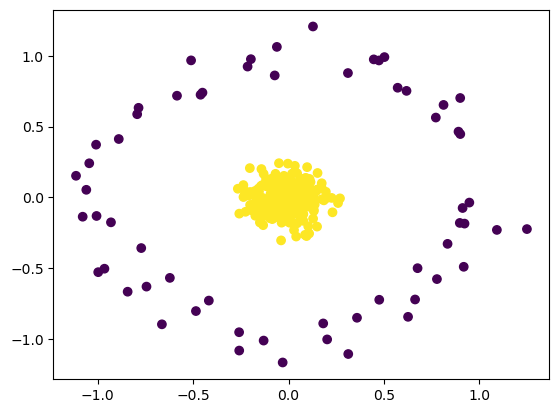

In [2]:
# Data - Percentage of outliers: 20% (relevant für OCSVM)
X, Y = datasets.make_circles(n_samples=(60, 300), factor=0, noise=0.1, random_state=0, shuffle=True)  
# number of zeros: 60, number of ones: 300

plt.scatter(X[:,0], X[:,1],c=Y)

In [3]:
# Train-Test-Split
x_train = X[:180]
y_train = Y[:180]
x_test = X[180:]
y_test = Y[180:]

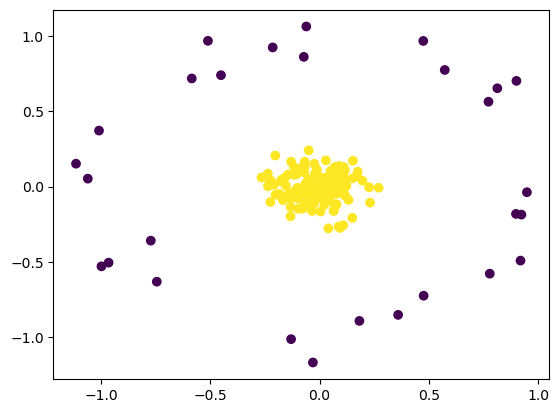

In [4]:
plt.scatter(x_train[:,0], x_train[:,1],c=y_train)

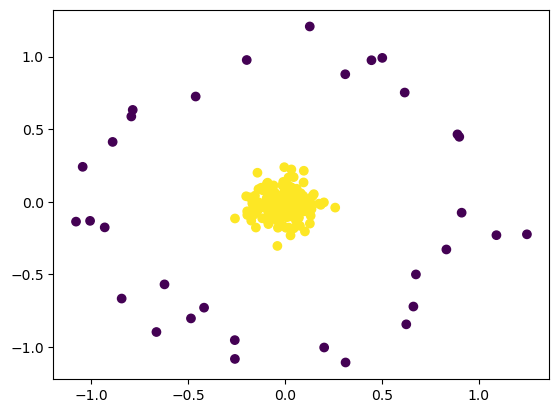

In [5]:
# Scatter plot of the test data
plt.scatter(x_test[:,0], x_test[:,1],c=y_test)

OneClassSVM(kernel='poly', nu=0.1)
Train accuracy: 90.556%


Text(0.5, 1.0, 'Accuracy of the training data')

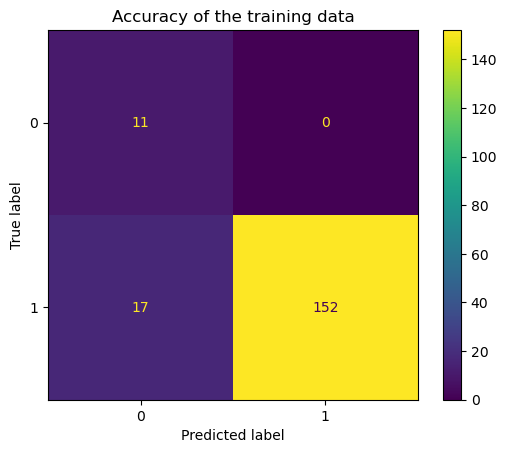

In [6]:
# Grid search for the best hyperparameters to find (nu, kernel) + one class SVM classifier
param_grid = [
    {"kernel": ["linear", "poly", "rbf", "sigmoid"],
     "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }
]

svm = OneClassSVM()
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(x_train, y_train)
print(grid_search.best_estimator_) 

one_class_svm = OneClassSVM(kernel="poly", nu=0.1)

# Accuracy of the training dataset
one_class_svm.fit(x_train, y_train)
predictions = one_class_svm.predict(x_train)
true_values = y_train

# convert the -1 values to 0
for i in range(len(x_train)):
    if predictions[i] == -1:
        predictions[i] = 0

#print(predictions)
accuracy_train = accuracy_score(true_values, predictions)
print("Train accuracy: %.3f%%" % (accuracy_train*100))

cm = confusion_matrix(predictions, true_values)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot() 
cmd.ax_.set_title("Accuracy of the training data")

Test accuracy: 79.444%


Text(0.5, 1.0, 'Accuracy of the testing data')

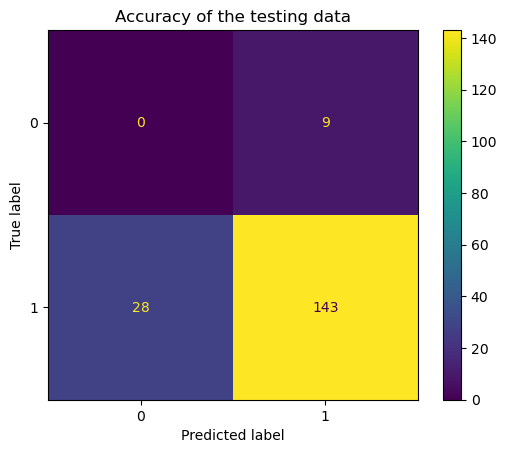

In [7]:
# Accuracy of the training dataset
predictions_test = one_class_svm.predict(x_test)

# convert the -1 values to 0
for i in range(len(x_test)):
    if predictions_test[i] == -1:
        predictions_test[i] = 0

#print(predictions)
accuracy_test = accuracy_score(true_values, predictions_test)
print("Test accuracy: %.3f%%" % (accuracy_test*100))

cm = confusion_matrix(predictions_test, true_values)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot() 
cmd.ax_.set_title("Accuracy of the testing data")

## Part 2 - Training an OC-SVM Classifier for the NSL-KDD Dataset
3. Führen Sie Preprocessing der Daten aus.
    - Skalieren Sie die numerischen Features.
    - One-hot-encoden Sie die kategorischen Features.
4. Trainieren Sie einen OC-SVM Classifier für den NSL-KDD Datensatz (siehe [NSL-KDD](https://www.kaggle.com/datasets/hassan06/nslkdd)).

### Data Preprocessing

In [8]:
data_train = pd.read_csv("KDDTrain+.txt")

columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

# feature names
data_train.columns = columns

data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

print(data_train['protocol_type'])

0         udp
1         tcp
2         tcp
3         tcp
4         tcp
         ... 
125967    tcp
125968    udp
125969    tcp
125970    tcp
125971    tcp
Name: protocol_type, Length: 125972, dtype: object


In [9]:
# scale the numerical data and one-hot encode the categorical data

# categorical features
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    # Skaliere numerische Features mit sklearns RobustScaler    
    # dataframe[row, column]
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 1
    dataframe.loc[dataframe['outcome'] != 1, "outcome"] = -1
    
    for column in data_train.columns:
        if column not in cat_cols:
            transform = RobustScaler().fit_transform(dataframe[column].to_numpy().reshape(-1,1))
            dataframe[column] = transform.reshape(-1)
  
    # One-hot-encode kategorische Features (nur nötig für 'protocol_type', 'service', 'flag')    
    features = ['protocol_type', 'service', 'flag']
    
    for item in features:
        onehot = OneHotEncoder(sparse_output=False).fit_transform(dataframe[item].to_numpy().reshape(-1,1))
        #dataframe[item] = pd.get_dummies(dataframe[item])
        dataframe[item] = np.argmax(onehot, axis=1)
    
    print(dataframe['protocol_type'])   # all encoded to the same value??
    return dataframe

scaled_train = preprocess(data_train)

0         2
1         1
2         1
3         1
4         1
         ..
125967    1
125968    2
125969    1
125970    1
125971    1
Name: protocol_type, Length: 125972, dtype: int64


In [10]:
print(data_train['srv_diff_host_rate'])
scaled_train['srv_diff_host_rate']

0         0.00
1         0.00
2         0.00
3         0.09
4         0.00
          ... 
125967    0.00
125968    0.00
125969    0.00
125970    0.00
125971    0.00
Name: srv_diff_host_rate, Length: 125972, dtype: float64


0         0.00
1         0.00
2         0.00
3         0.09
4         0.00
          ... 
125967    0.00
125968    0.00
125969    0.00
125970    0.00
125971    0.00
Name: srv_diff_host_rate, Length: 125972, dtype: float64

### Training a SVM Classifier

In [11]:
# Train-Test-Split
X = scaled_train.drop(['outcome'], axis=1)
y = scaled_train['outcome'] # value we are predicting
xtrain, xtest, ytrain, ytest = train_test_split(X[:50000], y[:50000], test_size=0.5, random_state=42)

# Anteil von Outliers (relevant für OCSVM)
from collections import Counter
counter = {}

for i in y:
    if i not in counter:
        counter[i] = 0
    counter[i] += 1
print("Percentage of outliers: %.3f%%" % (counter[-1]*100/(counter[1]+counter[-1])))

Percentage of outliers: 46.542%


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END ...........................nu=0.1;, score=-0.847 total time=   4.3s
[CV 2/3] END ...........................nu=0.1;, score=-1.587 total time=   4.6s
[CV 3/3] END ...........................nu=0.1;, score=-1.517 total time=   4.2s
[CV 1/3] END ...........................nu=0.2;, score=-0.978 total time=  10.7s
[CV 2/3] END ...........................nu=0.2;, score=-1.462 total time=  11.8s
[CV 3/3] END ...........................nu=0.2;, score=-1.517 total time=  10.8s
[CV 1/3] END ...........nu=0.30000000000000004;, score=-1.385 total time=  17.1s
[CV 2/3] END ...........nu=0.30000000000000004;, score=-1.408 total time=  17.4s
[CV 3/3] END ...........nu=0.30000000000000004;, score=-1.376 total time=  18.2s
[CV 1/3] END ...........................nu=0.4;, score=-1.311 total time=  23.3s
[CV 2/3] END ...........................nu=0.4;, score=-1.330 total time=  22.4s
[CV 3/3] END ...........................nu=0.4;, 

Text(0.5, 1.0, 'Accuracy of the training data')

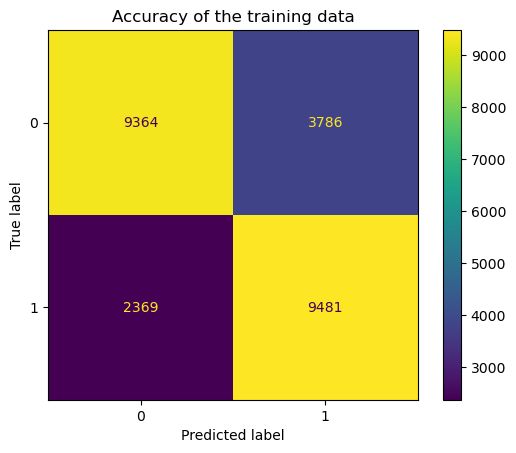

In [12]:
# Classifier  

parameters = [
    {"kernel": ["linear", "poly", "rbf", "sigmoid"],
     "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
]
param = {'nu': np.arange(0.1, 0.9, 0.1)}

one_class_svm = OneClassSVM()
grid = GridSearchCV(one_class_svm, param, cv=3, scoring="neg_mean_squared_error", verbose=3)
#print(grid_search.best_estimator_)
svm = OneClassSVM(nu=0.1)

grid.fit(xtrain, ytrain)
predictions = grid.predict(xtest)
ytest = ytest.astype(int)

accuracy_train = accuracy_score(ytest, predictions)
print("Train accuracy: %.3f%%" % (accuracy_train*100))

cm = confusion_matrix(predictions, ytest)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot() 
cmd.ax_.set_title("Accuracy of the training data")

In [13]:
grid.best_params_

{'nu': 0.5}